# AD-Tech Analysis

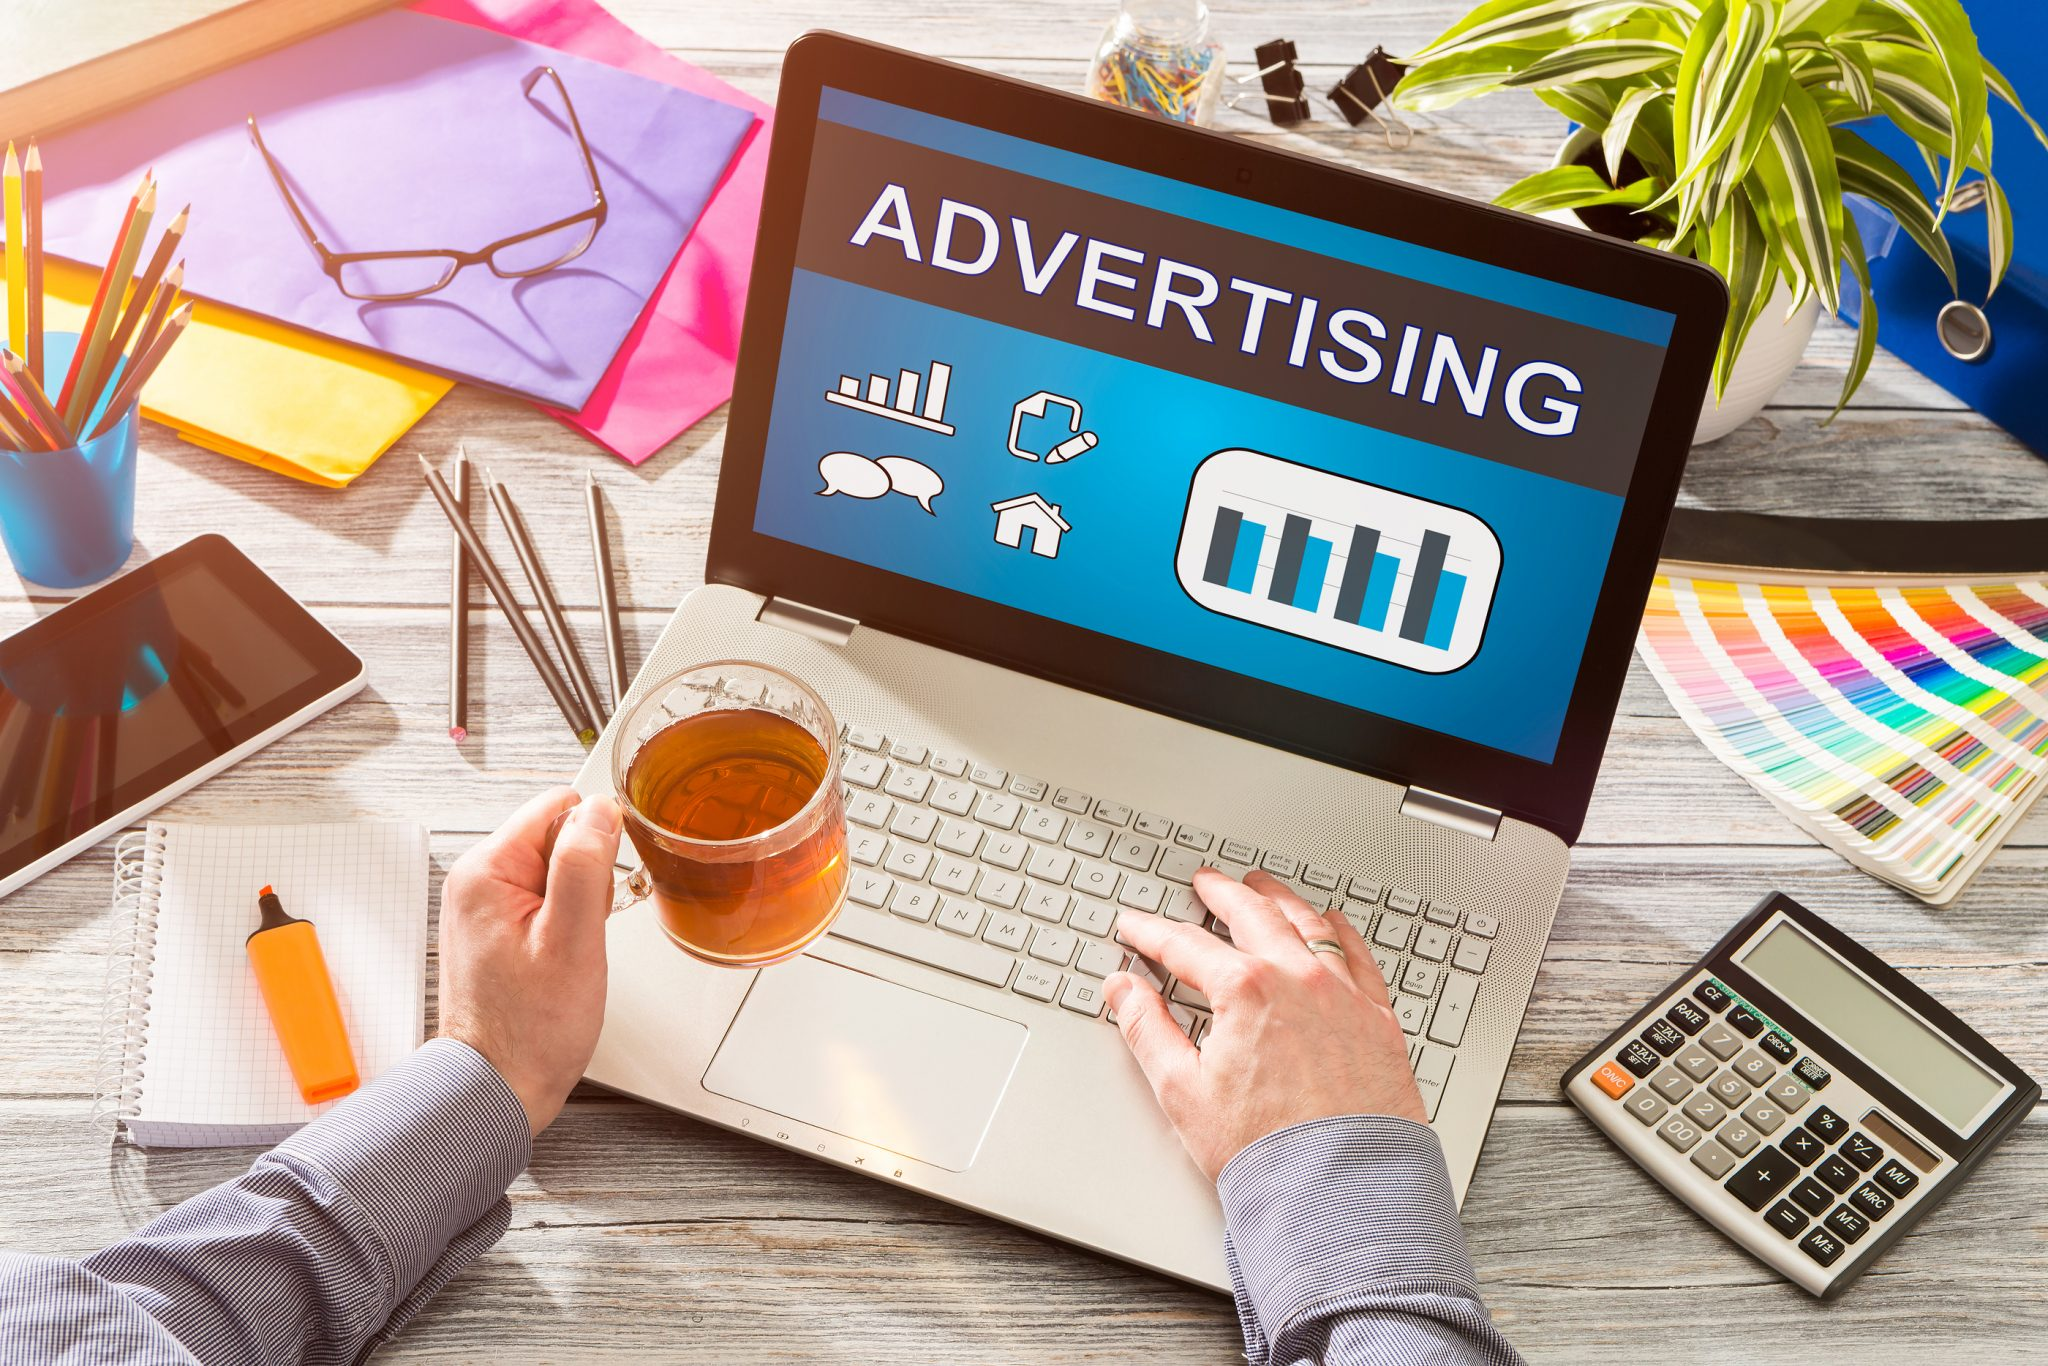

In [ ]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.style.use('bmh')

In [ ]:
ADV = pd.read_csv('../input/adtech/AD-Tech.csv')

# Data Exploration

In [ ]:
ADV.head()

In [ ]:
ADV.info()

In [ ]:
ADV.describe()

In [ ]:
#total Revenue based on Device type
sns.catplot(x="device_category_id", y="total_revenue", data=ADV, height = 8, aspect = 1.5)

In [ ]:
#Total revenue on Different websites
sns.catplot(x="site_id", y="total_revenue", data=ADV, height = 8, aspect = 1.5)
plt.show()

In [ ]:
#total impressions by different devices
sns.catplot(x="device_category_id", y="total_impressions", data=ADV, height = 8, aspect = 1.5)

In [ ]:
#Total Impressions on different websites
sns.catplot(x="site_id", y="total_impressions", data=ADV, height = 8, aspect = 1.5)

In [ ]:
sns.kdeplot(ADV['total_revenue'], shade=True);

In [ ]:
sns.kdeplot(ADV['total_impressions'], shade=True);

In [ ]:
#skewness and kurtosis
print("Skewness: %f" % ADV['total_revenue'].skew())
print("Kurtosis: %f" % ADV['total_revenue'].kurt())

In [ ]:
print("Skewness: %f" % ADV['total_impressions'].skew())
print("Kurtosis: %f" % ADV['total_impressions'].kurt())

In [ ]:
sns.jointplot(x=ADV['total_revenue'], y=ADV['total_impressions'], height = 10);

In [ ]:
list(set(ADV.dtypes.tolist()))

In [ ]:
ADV_num = ADV.select_dtypes(include = ['float64', 'int64'])
ADV_num.head()

In [ ]:
ADV_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

Now I am trying to find which features are strongly correlated with total impression and total revenue
I am storing them in a var called golden_features_list. We'll reuse our ADV_num dataset to do so.

In [ ]:

df_num_corr = ADV_num.corr()['total_impressions'][:-1] # -1 because the latest row is total impression
golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("There are {} strongly correlated values with total impressions:\n{}".format(len(golden_features_list), golden_features_list))

In [ ]:
df_num_cor = ADV_num.corr()['total_revenue'][:-1] # -1 because the latest row is total revenue
golden_features_revenue_list = df_num_cor[abs(df_num_cor) > 0.5].sort_values(ascending=False)
print("There are {} strongly correlated values with total revenue:\n{}".format(len(golden_features_revenue_list), golden_features_revenue_list))

In [ ]:
for i in range(0, len(ADV_num.columns), 5):
    sns.pairplot(data=ADV_num,
                x_vars=ADV_num.columns[i:i+5],
                y_vars=['total_impressions'])

In [ ]:
for i in range(0, len(ADV_num.columns), 5):
    sns.pairplot(data=ADV_num,
                x_vars=ADV_num.columns[i:i+5],
                y_vars=['total_revenue'])
plt.show()

In [ ]:
# feature to Feature relation

corr = ADV_num.drop('total_revenue', axis=1).corr() # We already examined total revenue correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

# Training Various models to make prediction based on Co-relation between Fields

# Predicting AD-Type Using PCA and Logistic Regression

In [ ]:
X1 = ADV.iloc[:, np.r_[1:2, 3:6, 7:8, 12:16]].values
y1 = ADV.iloc[:, 2:3].values

In [ ]:
#Spliting Data
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

In [ ]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X1_train = sc.fit_transform(X1_train)
X1_test = sc.transform(X1_test)

In [ ]:
#Applying PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X1_train = pca.fit_transform(X1_train)
X1_test = pca.transform(X1_test)

In [ ]:
#Training Logostic Regression Model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
LR_model = classifier.fit(X1_train, np.ravel(y1_train))

In [ ]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
y1_pred = LR_model.predict(X1_test)
cm = confusion_matrix(y1_test, y1_pred)
print(cm)
accuracy_score(y1_test, y1_pred)

# Predicting Revenue based on Impressions using Random forest regressor

In [ ]:
X2 = ADV.iloc[:, np.r_[12:13, 14:16]].values
y2 = ADV.iloc[:, 13:14].values

In [ ]:
#Spiliting Data
from sklearn.model_selection import train_test_split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 1/3, random_state = 0)

In [ ]:
# Training Random Forest Model
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 150, random_state = 0)
rf_model = regressor.fit(X2_train, np.ravel(y2_train))

In [ ]:
y2_pred = rf_model.predict(X2_test)

In [ ]:
#comparision between pred_values and actual_values
y2_pred = regressor.predict(X2_test)
np.set_printoptions(precision=2)
print(np.concatenate((y2_pred.reshape(len(y2_pred),1), y2_test.reshape(len(y2_test),1)),1))

# Impressions vs Revenue using Linear Regression

In [ ]:
X3 = ADV.iloc[:, 13:14].values
y3 = ADV.iloc[:, 12:13].values

In [ ]:
#Spiliting Data
from sklearn.model_selection import train_test_split
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 1/3, random_state = 0)

In [ ]:
#Training Linear Regression model
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
Lrr_model =regressor.fit(X3_train, y3_train)

In [ ]:
y3_pred = Lrr_model.predict(X3_test)

In [ ]:
plt.scatter(X3_train, y3_train, color = 'red')
plt.plot(X3_train, Lrr_model.predict(X3_train), color = 'blue')
plt.title('Reveneu vs Total Impressions (Training set)')
plt.xlabel('Revenue')
plt.ylabel('Total Impression')
plt.show()

In [ ]:
plt.scatter(X3_test, y3_test, color = 'red')
plt.plot(X3_train, Lrr_model.predict(X3_train), color = 'blue')
plt.title('Reveneu vs Total Impressions (Test set)')
plt.xlabel('Revenue')
plt.ylabel('Impressions')
plt.show()

# Predicting device_Category_ID based on total_impressions, measurable_impressions and viewable_impressions using XG Boost Model

In [ ]:
X4 = ADV.iloc[:, np.r_[12:13, 14:16]].values
y4 = ADV.iloc[:, 4:5].values

In [ ]:
#Spliting the Data
from sklearn.model_selection import train_test_split
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size = 0.25, random_state = 0)

In [ ]:
#Performing Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X4_train = sc.fit_transform(X4_train)
X4_test = sc.transform(X4_test)

In [ ]:
#Training XGBoost Model
from xgboost import XGBClassifier
classifier = XGBClassifier()
XG_model=classifier.fit(X4_train, y4_train)

In [ ]:
y4_pred = XG_model.predict(X4_test)
print(np.concatenate((y4_pred.reshape(len(y4_pred),1), y4_test.reshape(len(y4_test),1)),1))

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y4_test, y4_pred)
print(cm)
accuracy_score(y4_test, y4_pred)

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = XG_model, X = X4_train, y = y4_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

# Predicting Monetization using KNN-model based on site_id, advertiser_id and Revenue

In [ ]:
X5 = ADV.iloc[:, np.r_[1:2, 5:6, 13:14]].values
y5 = ADV.iloc[:, 10:11].values

In [ ]:
#Spliting The Data
from sklearn.model_selection import train_test_split
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size = 0.25, random_state = 0)

In [ ]:
# Feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X5_train = sc.fit_transform(X5_train)
X5_test = sc.transform(X5_test)

In [ ]:
#Training KNN-Model
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn_model = classifier.fit(X5_train, np.ravel(y5_train))

In [ ]:
y5_pred = knn_model.predict(X5_test)
print(np.concatenate((y5_pred.reshape(len(y5_pred),1), y5_test.reshape(len(y5_test),1)),1))

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y5_test, y5_pred)
print(cm)
accuracy_score(y5_test, y5_pred)

# Prediction of AD-Type using Kernel SVM

In [ ]:
#predicting ADType based on site_id, advertiser_id, total_impressions, measurable impressions, viewable impressions
X6 = ADV.iloc[:, np.r_[1:2, 5:6, 12:13, 14:16]].values
y6 = ADV.iloc[:, np.r_[2:3]].values

In [ ]:
#Spliting Data
from sklearn.model_selection import train_test_split
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6, test_size = 0.2, random_state = 0)

In [ ]:
#feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X6_train = sc.fit_transform(X6_train)
X6_test = sc.transform(X6_test)

In [ ]:
#Training Model
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
svm_model = classifier.fit(X6_train, np.ravel(y6_train))

In [ ]:
y6_pred = svm_model.predict(X6_test)
print(np.concatenate((y6_pred.reshape(len(y6_pred),1), y6_test.reshape(len(y6_test),1)),1))

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y6_test, y6_pred)
print(cm)
accuracy_score(y6_test, y6_pred)